<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3d_OSI_SAF_SST_mapping_NAR.ipynb" target="_blank"><< Mapping NAR SST products</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sst/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_sst_introductory%2F1_3a_OSI_SAF_SST_mapping_Metop_Metagranules.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea surface temperature: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb" target="_blank">1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb</a>**
</div>
<hr>

# 1.3e Mapping Metop SST IASI

### Data used 

| Product Description | Product Navigator | OSI SAF website link | OSI SAF Identifier |
|:--------------------:|:-------------:|:-----------------:|:-----------------:|
| Infrared Atmospheric Sounding Interferometer Sea Surface Temperature | EO:EUM:DAT:METOP:IASI-SST | <a href="https://osi-saf.eumetsat.int/products/osi-208-b" target="_blank">link</a>| OSI-208-b | 


### Learning outcomes

At the end of this notebook you will know;
* How to open IASI Metop SST netcdf 
* Map SST using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Defining geographical area](#section1)
 1. [Setting parameters](#section2)
 1. [Map SST](#section3)
 
<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import cmcrameri                   # scientific colormaps for data visualisation
import numpy as np                 # a library that supports array manipulation
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

##
<div class="alert alert-info" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `add_colorbar` create a colorbar of the image im.

In [2]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.1,0.1,0.75,0.02))
        ax = fig.add_axes([0.43,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.85,0.2,0.02,0.85))
        ax = fig.add_axes([0.8,.1,0.1,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    logo = plt.imread("../OSISAF_Name_Colour.png")
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('SST [°C]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

##
<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting parameters
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [3]:
directory = 'products/iasi'

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [4]:
cmap = mpl_cm.get_cmap('RdYlBu_r')
#cmap = cmocean.cm.thermal

##
<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Map SST
[Back to top](#TOC-TOP)

</div>

IASI Sea Surface Temperature Products are based on several 3 minutes data. It is possible to combine it and have a global map in one day.

### Global Map

Mapping figure based on retrieved metagranules from IASI data in one day

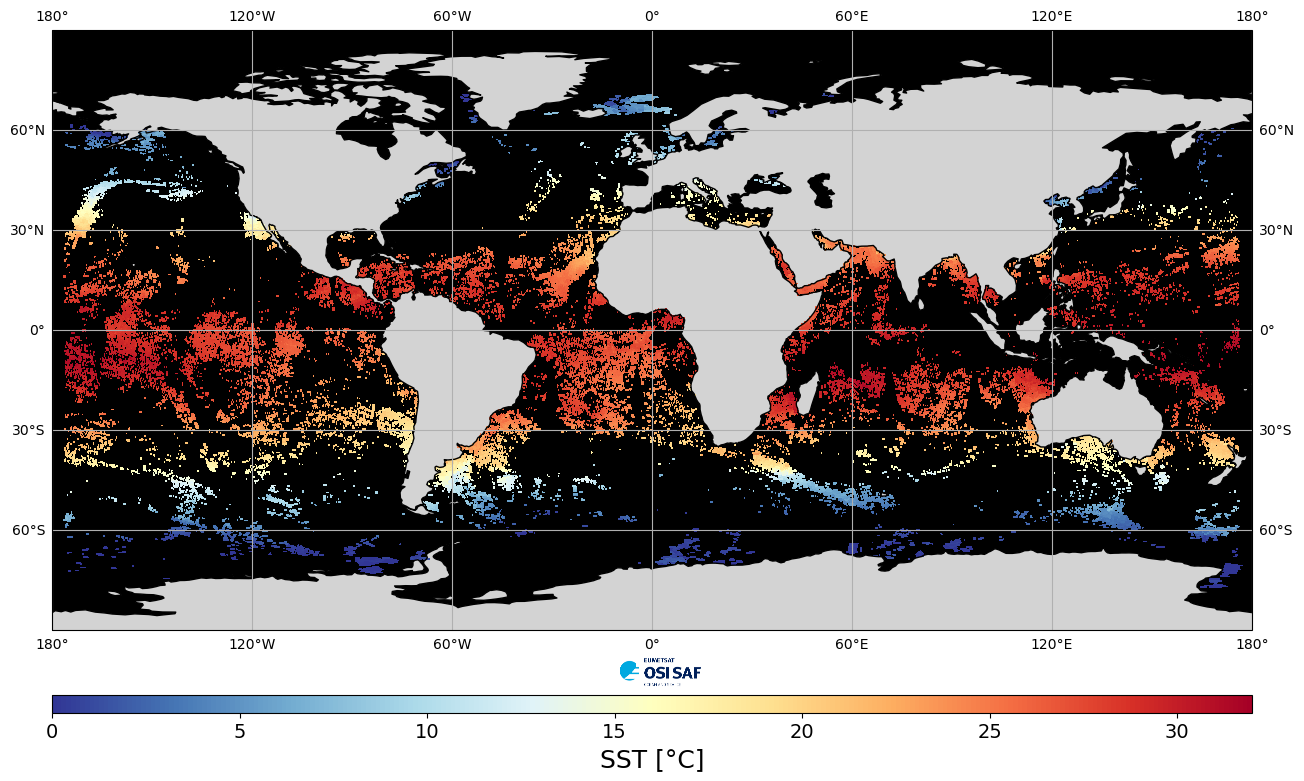

In [17]:
# Define figure size
fig = plt.figure(figsize=(16,9))

# Set input and output projection of data
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree() # Can be change

# define title
# plt.title("IASI  - Plate Carree", fontsize=16)


# define plot carateristics
ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
ax.set_global()    # have a global map
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey') # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline



# open and plot data
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)
        lat = nc.variables['lat'][:]
        lon = nc.variables['lon'][:]
        sst = nc.variables['sea_surface_temperature'][:]
        ql  = nc.variables['quality_level'][:]
        nc.close()
        
        # Use only SST with quality_level > 2
        sst_ql345 = np.ma.masked_where(ql<3, sst)
        # Select longitude - debug map
        lon_sel = 176
        sst_ql345 = np.ma.masked_where(lon<-lon_sel, sst_ql345[0,:,:])
        sst_ql345 = np.ma.masked_where(lon>lon_sel, sst_ql345)

        # plotting sst
        im = plt.pcolormesh(lon, lat, sst_ql345[:,:]-273.15, transform=data_projection, cmap=cmap)
        
    # set the min and max temperature for apropriate visualisation
    im.set_clim(0,32)

# Adding a colorbar       
add_colorbar(im, fig, orientation="horizontal", cmap=cmap)

### Mapping One granule
Let's map a one granule to see what it is look like.

With a Global map

In [5]:
# Select granule file 
filename = '20240109001759-OSISAF-L2P_GHRSST-SSTskin-IASI_SST_METOP_B-sstiasi_metop01_20240109_001759_58679-v02.0-fv01.0.nc'

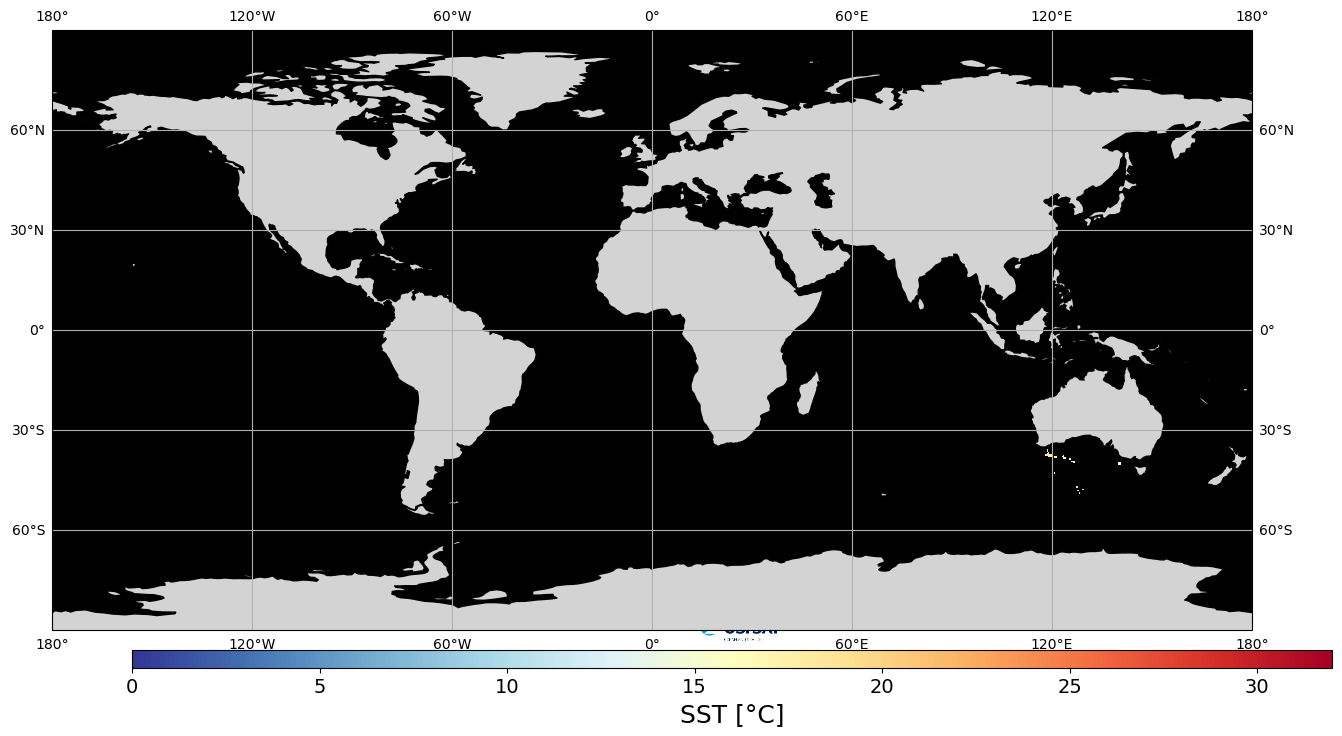

In [6]:
# Define figure size
fig = plt.figure(figsize=(16,9))

# Set input and output projection of data
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree() # Can be change

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()    # have a global map
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey') # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline

# open and plot data
nc = xr.open_dataset(directory + '/' + filename)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
sst = nc.variables['sea_surface_temperature'][:]
ql  = nc.variables['quality_level'][:]
nc.close()
        
# Use only SST with quality_level > 2
sst_ql345 = np.ma.masked_where(ql<3, sst)
# Select longitude - debug map
lon_sel = 176
sst_ql345 = np.ma.masked_where(lon<-lon_sel, sst_ql345[0,:,:])
sst_ql345 = np.ma.masked_where(lon>lon_sel, sst_ql345)

# plotting sst
im = plt.pcolormesh(lon, lat, sst_ql345[:,:]-273.15, transform=data_projection, cmap=cmap)
        
# set the min and max temperature for apropriate visualisation
im.set_clim(0,32)

# Adding a colorbar       
# axc = fig.add_axes((0.85,0.05,0.02,0.85))
# cb = plt.colorbar(im, orientation='vertical', cax=axc)
# cb.set_label('SST [°C]', fontsize=18)
# cb.ax.tick_params(labelsize=14)

# logo
# logo = plt.imread("../OSISAF_Name_Colour.png")


def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.1,0.1,0.75,0.02))
        ax = fig.add_axes([0.43,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.85,0.2,0.02,0.85))
        ax = fig.add_axes([0.8,.1,0.1,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    logo = plt.imread("../OSISAF_Name_Colour.png")
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('SST [°C]', fontsize=18)
    cb.ax.tick_params(labelsize=14)
    
 # Adding a colorbar       
add_colorbar(im, fig, orientation="horizontal", cmap=cmap)

Let's zoom on it

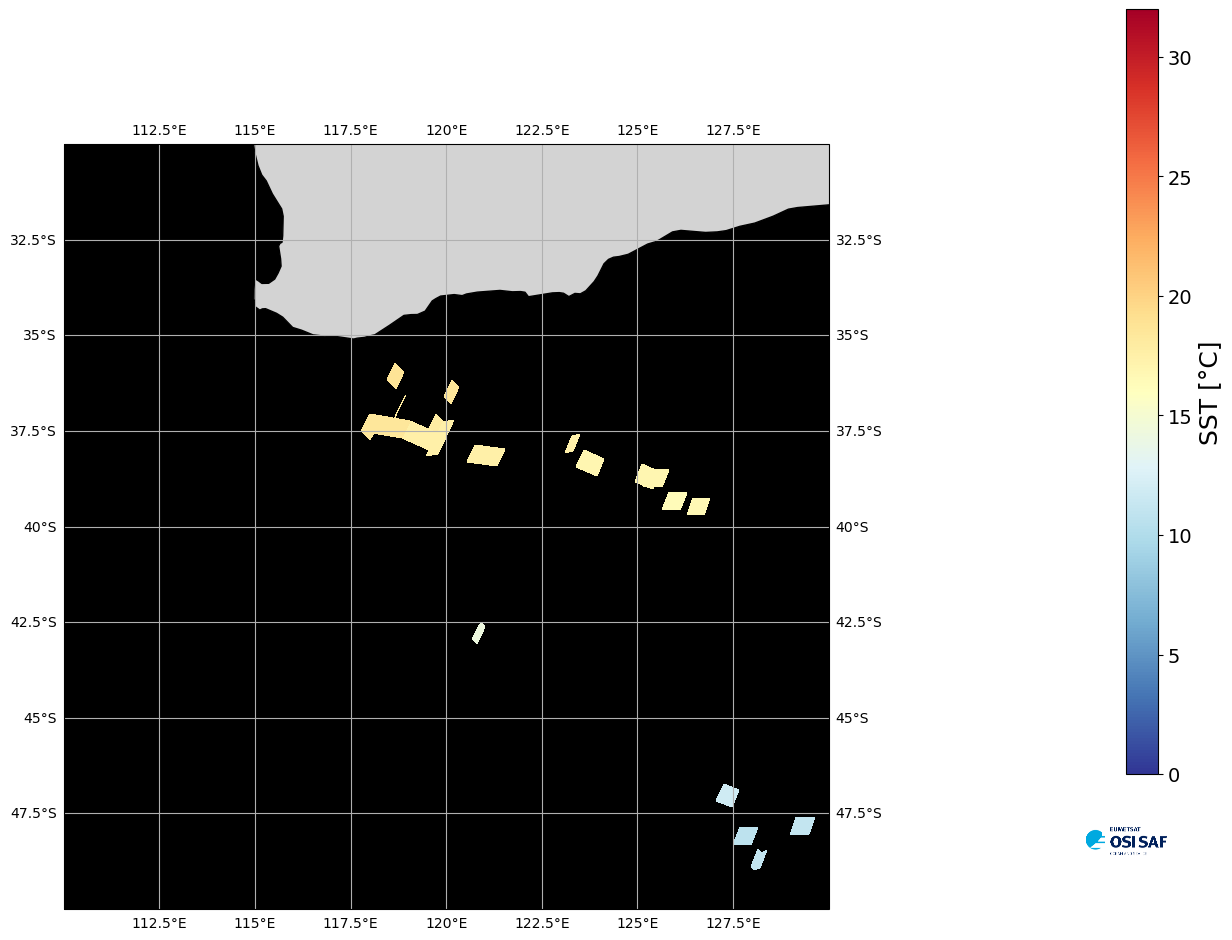

In [9]:
# Select area
lon_min = 110
lon_max = 130
lat_min = -50
lat_max = -30
# Define figure size
fig = plt.figure(figsize=(16,9))

# Set input and output projection of data
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree() # Can be change

# define title
# plt.title("IASI  - Plate Carree", fontsize=16)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey') # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline

# open and plot data
nc = xr.open_dataset(directory + '/' + filename)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
sst = nc.variables['sea_surface_temperature'][:]
ql  = nc.variables['quality_level'][:]
nc.close()
        
# Use only SST with quality_level > 2
sst_ql345 = np.ma.masked_where(ql<3, sst)
# Select longitude - debug map
lon_sel = 176
sst_ql345 = np.ma.masked_where(lon<-lon_sel, sst_ql345[0,:,:])
sst_ql345 = np.ma.masked_where(lon>lon_sel, sst_ql345)

# plotting sst
im = plt.pcolormesh(lon, lat, sst_ql345[:,:]-273.15, transform=data_projection, cmap=cmap)
        
# set the min and max temperature for apropriate visualisation
im.set_clim(0,32)

# Adding a colorbar       
add_colorbar(im, fig, orientation="vertical", cmap=cmap)

##
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3d_OSI_SAF_SST_mapping_NAR.ipynb" target="_blank"><< Mapping NAR SST products</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>